In [1]:
from scipy import misc, ndimage, signal
from sklearn.model_selection  import train_test_split
import numpy
import numpy as np
import random
import ntpath
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from keras import optimizers 
from keras import regularizers
import tensorflow as tf
import cv2
from keras import backend as K
from time import time
import time as tm
import datetime
from operator import itemgetter
import glob
from skimage.util.shape import view_as_blocks
from keras.utils import np_utils
from keras.utils import to_categorical

In [2]:
!nvidia-smi

Mon Aug 17 23:07:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 450.57       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   49C    P8     6W / 250W |     54MiB / 11016MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
################################################## 30 SRM FILTERS
srm_weights = np.load('SRM_Kernels1.npy') 
biasSRM=numpy.ones(30)
print (srm_weights.shape)
################################################## TLU ACTIVATION FUNCTION
T3 = 3;
def Tanh3(x):
    tanh3 = K.tanh(x)*T3
    return tanh3
##################################################

(5, 5, 1, 30)


In [4]:
path_log_base = './logs'
path_img_base = './images'

In [5]:
def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, model_name=""):
    start_time = tm.time()
    log_dir=path_log_base+"/"+model_name+"_"+str(datetime.datetime.now().isoformat()[:19].replace("T", "_").replace(":","-"))
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    filepath = log_dir+"/saved-model-{epoch:03d}-{val_accuracy:.4f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=False, mode='max')
    model.reset_states()
    
    #VALORES EN TRAIN TEST Y VALIDACIÓN INICIALES, GRÁFICOS
    global lossTEST
    global accuracyTEST
    global lossTRAIN
    global accuracyTRAIN
    global lossVALID
    global accuracyVALID
    lossTEST,accuracyTEST   = model.evaluate(X_test, y_test,verbose=None)
    lossTRAIN,accuracyTRAIN = model.evaluate(X_train, y_train,verbose=None)
    lossVALID,accuracyVALID = model.evaluate(X_valid, y_valid,verbose=None)

    global history
    global model_Name
    global log_Dir
    model_Name = model_name
    log_Dir = log_dir
    
    history=model.fit(X_train, y_train, epochs=epochs, 
                      callbacks=[tensorboard,checkpoint], 
                      batch_size=batch_size,validation_data=(X_valid, y_valid),verbose=1)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
     
    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    
    print("\n")
    print(log_dir)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [6]:
def Final_Results_Test(PATH_trained_models):
    global AccTest
    global LossTest
    AccTest = []
    LossTest= [] 
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model = tf.keras.models.load_model(PATH_trained_models+'/'+filename, custom_objects={'Tanh3':Tanh3})
            loss,accuracy = model.evaluate(X_test, y_test,verbose=0)
            print(f'Loss={loss:.4f} y Accuracy={accuracy:0.4f}'+'\n')
            BandAccTest  = accuracy
            BandLossTest = loss
            AccTest.append(BandAccTest)    #Valores de la precisión en Test, para graficar junto a valid y train
            LossTest.append(BandLossTest)  #Valores de la perdida en Test, para graficar junto a valid y train
            
            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename
    
    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y Accuracy={B_accuracy:0.4f}'+'\n')

In [7]:
def graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID):
    numbers=AccTest
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Test Accuracy {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['accuracy']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Train Accuracy {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['val_accuracy']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Validation Accuracy {}, Época:{}\n".format(value, index+1))

    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 10))
        #Plot training & validation accuracy values
        plt.plot(np.concatenate([np.array([accuracyTRAIN]),np.array(history.history['accuracy'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyVALID]),np.array(history.history['val_accuracy'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyTEST]),np.array(AccTest)],axis=0)) #Test
        plt.title('Accuracy Vs Epoch')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.eps', format='eps')
        plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.svg', format='svg')
        plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.pdf', format='pdf')     
        plt.show()
        
        plt.figure(figsize=(10, 10))
        #Plot training & validation loss values
        plt.plot(np.concatenate([np.array([lossTRAIN]),np.array(history.history['loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossVALID]),np.array(history.history['val_loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossTEST]),np.array(LossTest)],axis=0)) #Test
        plt.title('Loss Vs Epoch')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.eps', format='eps')
        plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.svg', format='svg')
        plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.pdf', format='pdf') 
        plt.show() 

In [8]:
def split_spatial_image_steganalysis(NumTrain,NumValid,NumTest,r_s): #En pares de imágenes, total=10000
    #Controled randomized data for training
    X_train = np.concatenate([X_data_cover[:NumTrain],X_data_stego[:NumTrain]],axis=0)
    y_train = np.concatenate([y_data_cover[:NumTrain],y_data_stego[:NumTrain]],axis=0)
    X_dat0, X_dat1, y_dat0, y_dat1 = train_test_split(X_train, y_train, test_size=0.50, random_state=r_s) 
    X_train = np.concatenate([X_dat0,X_dat1],axis=0) 
    y_train = np.concatenate([y_dat0,y_dat1],axis=0) 
    
    #First cover and then stego
    X_valid = np.concatenate([X_data_cover[NumTrain:(NumTrain+NumValid)],X_data_stego[NumTrain:(NumTrain+NumValid)]],axis=0)
    y_valid = np.concatenate([y_data_cover[NumTrain:(NumTrain+NumValid)],y_data_stego[NumTrain:(NumTrain+NumValid)]],axis=0)
    X_test  = np.concatenate([X_data_cover[(NumTrain+NumValid):(NumTrain+NumValid+NumTest)],X_data_stego[(NumTrain+NumValid):(NumTrain+NumValid+NumTest)]],axis=0)
    y_test  = np.concatenate([y_data_cover[(NumTrain+NumValid):(NumTrain+NumValid+NumTest)],y_data_stego[(NumTrain+NumValid):(NumTrain+NumValid+NumTest)]],axis=0)
    return X_train,y_train,X_valid,y_valid,X_test,y_test

In [9]:
X = np.load('/media/ia/Datos1/DocReinel/DATABASES/COVER_STEGO_02_04bpp_size256/payload_04bpp/1WOW/BOSSbase1_01_train4000_valid1000_test5000/NPY/X_train.npy')
Xt = np.load('/media/ia/Datos1/DocReinel/DATABASES/COVER_STEGO_02_04bpp_size256/payload_04bpp/1WOW/BOSSbase1_01_train4000_valid1000_test5000/NPY/y_train.npy') 
Y = np.load('/media/ia/Datos1/DocReinel/DATABASES/COVER_STEGO_02_04bpp_size256/payload_04bpp/1WOW/BOSSbase1_01_train4000_valid1000_test5000/NPY/X_valid.npy')
Yt = np.load('/media/ia/Datos1/DocReinel/DATABASES/COVER_STEGO_02_04bpp_size256/payload_04bpp/1WOW/BOSSbase1_01_train4000_valid1000_test5000/NPY/y_valid.npy')
Z = np.load('/media/ia/Datos1/DocReinel/DATABASES/COVER_STEGO_02_04bpp_size256/payload_04bpp/1WOW/BOSSbase1_01_train4000_valid1000_test5000/NPY/X_test.npy')
Zt = np.load('/media/ia/Datos1/DocReinel/DATABASES/COVER_STEGO_02_04bpp_size256/payload_04bpp/1WOW/BOSSbase1_01_train4000_valid1000_test5000/NPY/y_test.npy')
print(X.shape)
print(Y.shape)
print(Z.shape)
print(Xt.shape)
print(Yt.shape)
print(Zt.shape)

(8000, 256, 256, 1)
(2000, 256, 256, 1)
(10000, 256, 256, 1)
(8000, 2)
(2000, 2)
(10000, 2)


In [10]:
X_data_cover = np.concatenate([X[:int(len(X)/2)],Y[:int(len(Y)/2)],Z[:int(len(Z)/2)]],axis=0)
X_data_stego = np.concatenate([X[int(len(X)/2):],Y[int(len(Y)/2):],Z[int(len(Z)/2):]],axis=0)
y_data_cover = np.concatenate([Xt[:int(len(Xt)/2)],Yt[:int(len(Yt)/2)],Zt[:int(len(Zt)/2)]],axis=0)
y_data_stego = np.concatenate([Xt[int(len(Xt)/2):],Yt[int(len(Yt)/2):],Zt[int(len(Zt)/2):]],axis=0)
print(X_data_cover.shape)
print(X_data_stego.shape)
print(y_data_cover.shape)
print(y_data_stego.shape)

(10000, 256, 256, 1)
(10000, 256, 256, 1)
(10000, 2)
(10000, 2)


In [11]:
def GBRAS_Net():
    tf.keras.backend.clear_session()
    #Inputs
    inputs = tf.keras.Input(shape=(256,256,1), name="input_1")
    #Layer 1
    layers = tf.keras.layers.Conv2D(30, (5,5), weights=[srm_weights,biasSRM], strides=(1,1), padding='same', trainable=False, activation=Tanh3, use_bias=True)(inputs)
    layers1 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 2
    layers = tf.keras.layers.DepthwiseConv2D(1)(layers1)
    layers = tf.keras.layers.SeparableConv2D(30,(3,3), padding='same', activation="elu",depth_multiplier=3)(layers) 
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 3
    layers = tf.keras.layers.DepthwiseConv2D(1)(layers)
    layers = tf.keras.layers.SeparableConv2D(30,(3,3), padding='same', activation="elu",depth_multiplier=3)(layers) 
    layers2 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    skip1 =   tf.keras.layers.Add()([layers1, layers2])
    #Layer 4
    layers = tf.keras.layers.Conv2D(30, (3,3), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(skip1) 
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 5
    layers = tf.keras.layers.Conv2D(30, (3,3), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 6
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)
    #Layer 7
    layers = tf.keras.layers.Conv2D(60, (3,3), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(layers) 
    layers3 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 8
    layers = tf.keras.layers.DepthwiseConv2D(1)(layers3)
    layers = tf.keras.layers.SeparableConv2D(60,(3,3), padding='same', activation="elu",depth_multiplier=3)(layers) 
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 9
    layers = tf.keras.layers.DepthwiseConv2D(1)(layers)
    layers = tf.keras.layers.SeparableConv2D(60,(3,3), padding='same', activation="elu",depth_multiplier=3)(layers) 
    layers4 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    skip2 =   tf.keras.layers.Add()([layers3, layers4])
    #Layer 10
    layers = tf.keras.layers.Conv2D(60, (3,3), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(skip2) 
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 11
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)
    #Layer 12
    layers = tf.keras.layers.Conv2D(60, (3,3), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(layers) 
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 13
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)
    #Layer 14
    layers = tf.keras.layers.Conv2D(60, (3,3), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(layers) 
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 15
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)
    #Layer 16
    layers = tf.keras.layers.Conv2D(30, (1,1), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(layers) 
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 17
    layers = tf.keras.layers.Conv2D(2, (1,1), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(layers) 
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 18
    layers = tf.keras.layers.GlobalAveragePooling2D(data_format="channels_last")(layers)
    #Layer 19
    predictions = tf.keras.layers.Softmax(axis=1)(layers)
    #Model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    #Optimizer
    optimizer=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    print ("Model GBRAS-Net Generated")
    #Model compilation
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


Model GBRAS-Net Generated
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 30) 780         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 30) 90          conv2d[0][0]                     
__________________________________________________________________________________________________
depthwise_conv2d (DepthwiseConv (None, 256, 256, 30) 60          batch_normalization[0][0]        
____________________________________________________________________

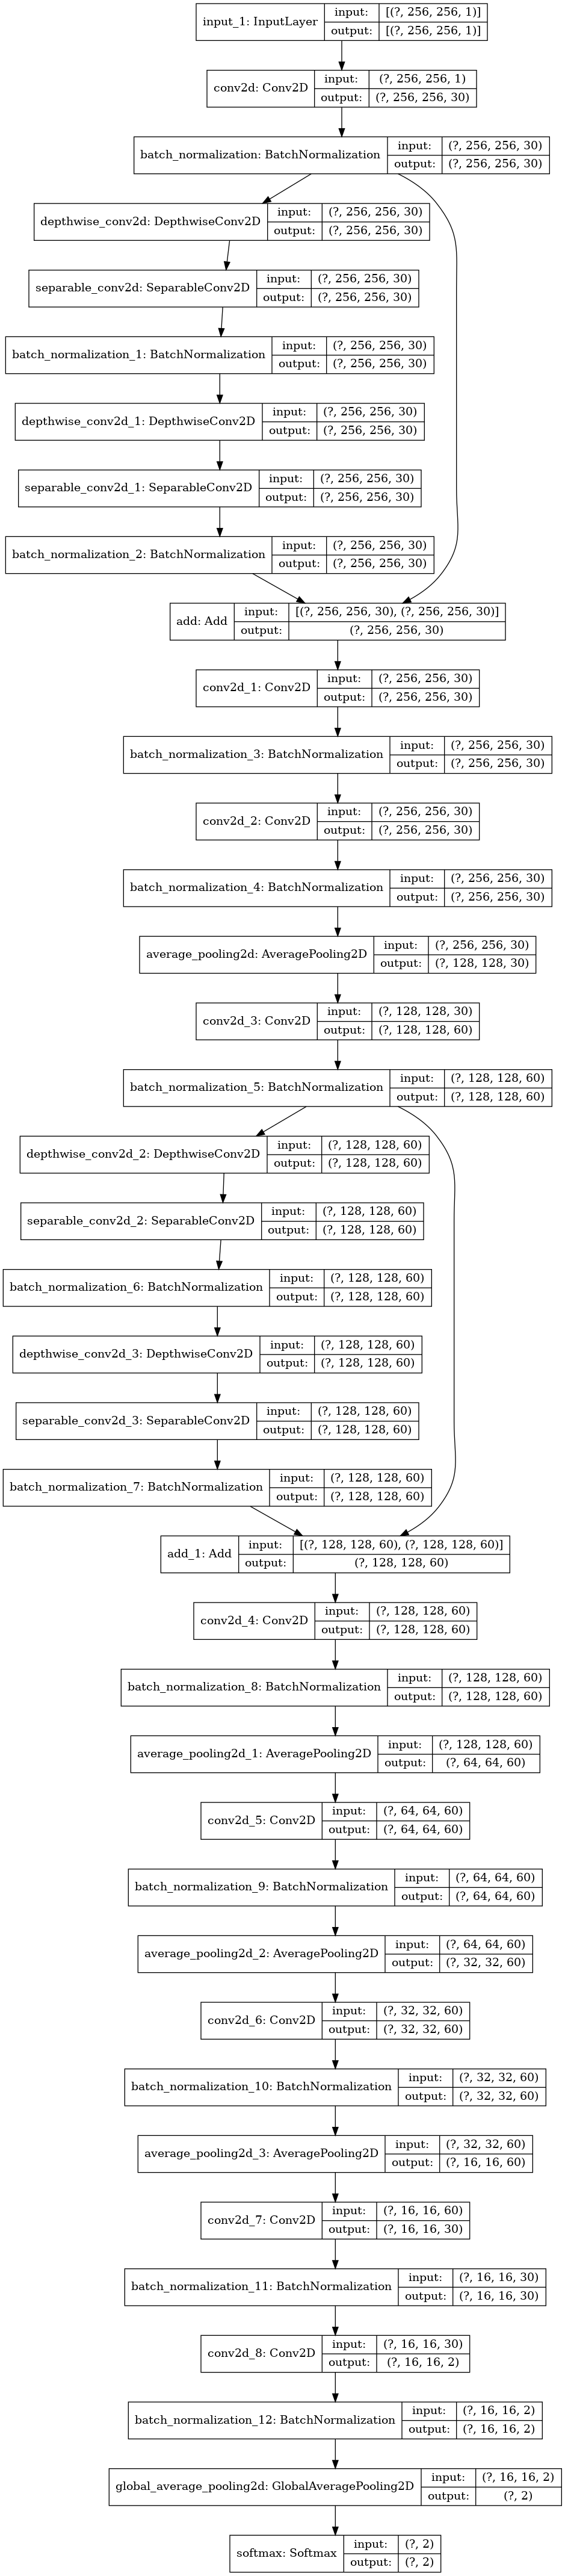

In [12]:
model = GBRAS_Net()
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

# 0 to 255

In [13]:
#En pares de imágenes, total=10000 TRAIN VALID TEST
X_train,y_train,X_valid,y_valid,X_test,y_test=split_spatial_image_steganalysis(4000,1000,5000,64) 

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)
print(X_train.min())
print(X_train.max())
print(X_valid.min())
print(X_valid.max())
print(X_test.min())
print(X_test.max())

(8000, 256, 256, 1)
(8000, 2)
(2000, 256, 256, 1)
(2000, 2)
(10000, 256, 256, 1)
(10000, 2)
0
255
0
255
0
255


In [14]:
model = GBRAS_Net()
train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=32, epochs=100, model_name="WOW_GBRAS-Net_0to255") 


Model GBRAS-Net Generated
Epoch 1/100
250/250 [==============================] - 281s 1s/step - loss: 0.6941 - accuracy: 0.5120 - val_loss: 0.6920 - val_accuracy: 0.5095
Epoch 2/100
250/250 [==============================] - 281s 1s/step - loss: 0.6897 - accuracy: 0.5271 - val_loss: 0.6780 - val_accuracy: 0.5695
Epoch 3/100
250/250 [==============================] - 281s 1s/step - loss: 0.6685 - accuracy: 0.5805 - val_loss: 0.6516 - val_accuracy: 0.6020
Epoch 4/100
250/250 [==============================] - 281s 1s/step - loss: 0.6449 - accuracy: 0.6045 - val_loss: 0.6735 - val_accuracy: 0.5710
Epoch 5/100
250/250 [==============================] - 281s 1s/step - loss: 0.6271 - accuracy: 0.6320 - val_loss: 0.6169 - val_accuracy: 0.6295
Epoch 6/100
250/250 [==============================] - 281s 1s/step - loss: 0.6093 - accuracy: 0.6528 - val_loss: 0.6024 - val_accuracy: 0.6480
Epoch 7/100
250/250 [==============================] - 281s 1s/step - loss: 0.6019 - accuracy: 0.6679 - val_lo

{'loss': 0.42939579486846924, 'accuracy': 0.8697999715805054}

In [15]:
Final_Results_Test(log_Dir) 

saved-model-001-0.5095.hdf5
Loss=0.6922 y Accuracy=0.5103

saved-model-002-0.5695.hdf5
Loss=0.6781 y Accuracy=0.5699

saved-model-003-0.6020.hdf5
Loss=0.6519 y Accuracy=0.5989

saved-model-004-0.5710.hdf5
Loss=0.6723 y Accuracy=0.5641

saved-model-005-0.6295.hdf5
Loss=0.6157 y Accuracy=0.6349

saved-model-006-0.6480.hdf5
Loss=0.6014 y Accuracy=0.6516

saved-model-007-0.6055.hdf5
Loss=0.6255 y Accuracy=0.6138

saved-model-008-0.6425.hdf5
Loss=0.5980 y Accuracy=0.6434

saved-model-009-0.7265.hdf5
Loss=0.5444 y Accuracy=0.7258

saved-model-010-0.7420.hdf5
Loss=0.5365 y Accuracy=0.7398

saved-model-011-0.7320.hdf5
Loss=0.5315 y Accuracy=0.7460

saved-model-012-0.7375.hdf5
Loss=0.5427 y Accuracy=0.7417

saved-model-013-0.7315.hdf5
Loss=0.5184 y Accuracy=0.7401

saved-model-014-0.7560.hdf5
Loss=0.5137 y Accuracy=0.7702

saved-model-015-0.7545.hdf5
Loss=0.4891 y Accuracy=0.7655

saved-model-016-0.7495.hdf5
Loss=0.5048 y Accuracy=0.7618

saved-model-017-0.7830.hdf5
Loss=0.5008 y Accuracy=0.787

Test Accuracy 0.881600022315979, Época:65

Test Accuracy 0.880299985408783, Época:98

Test Accuracy 0.8784999847412109, Época:72

Test Accuracy 0.8779000043869019, Época:76

Test Accuracy 0.8766000270843506, Época:86


Train Accuracy 0.9246249794960022, Época:99

Train Accuracy 0.9235000014305115, Época:98

Train Accuracy 0.9231250286102295, Época:100

Train Accuracy 0.9206249713897705, Época:96

Train Accuracy 0.9168750047683716, Época:97


Validation Accuracy 0.8700000047683716, Época:55

Validation Accuracy 0.8700000047683716, Época:98

Validation Accuracy 0.8694999814033508, Época:76

Validation Accuracy 0.8679999709129333, Época:65

Validation Accuracy 0.8679999709129333, Época:72



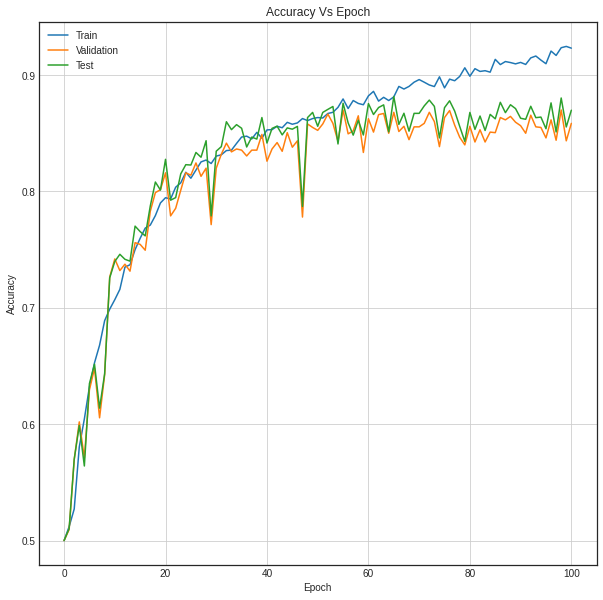

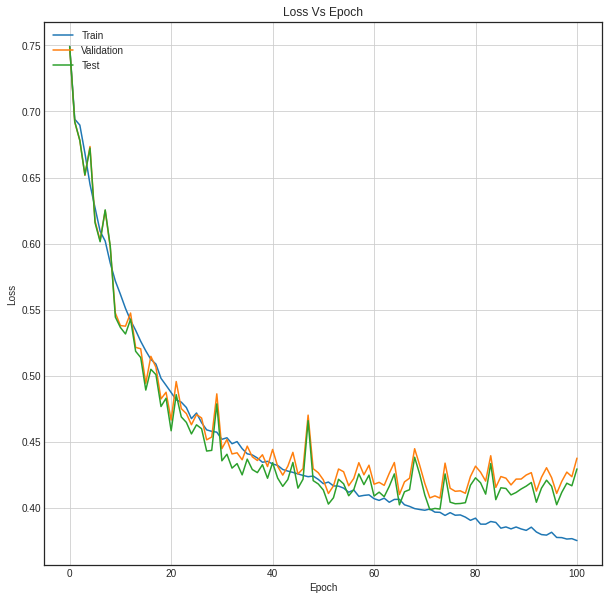

In [16]:
#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)


In [17]:
# SAVING FOR LOADING AND COMPARE
Acc_Train = np.concatenate([np.array([accuracyTRAIN]),np.array(history.history['accuracy'])],axis=0)
Acc_Valid = np.concatenate([np.array([accuracyVALID]),np.array(history.history['val_accuracy'])],axis=0)
Acc_Test  = np.concatenate([np.array([accuracyTEST]),np.array(AccTest)],axis=0)

Loss_Train= np.concatenate([np.array([lossTRAIN]),np.array(history.history['loss'])],axis=0)
Loss_Valid= np.concatenate([np.array([lossVALID]),np.array(history.history['val_loss'])],axis=0)
Loss_Test = np.concatenate([np.array([lossTEST]),np.array(LossTest)],axis=0)

name = "_0to255"
np.save("./history/Acc_Train"+name, Acc_Train)
np.save("./history/Acc_Valid"+name, Acc_Valid)
np.save("./history/Acc_Test"+name, Acc_Test)

np.save("./history/Loss_Train"+name, Loss_Train)
np.save("./history/Loss_Valid"+name, Loss_Valid)
np.save("./history/Loss_Test"+name, Loss_Test)


In [18]:
name = "_0to255.npy"
np.load("./history/Acc_Train"+name)
np.load("./history/Acc_Valid"+name)
np.load("./history/Acc_Test"+name)

np.load("./history/Loss_Train"+name)
np.load("./history/Loss_Valid"+name)
np.load("./history/Loss_Test"+name)

print(Acc_Train.shape)
print(Acc_Valid.shape)
print(Acc_Test.shape)

print(Loss_Train.shape)
print(Loss_Valid.shape)
print(Loss_Test.shape)


(101,)
(101,)
(101,)
(101,)
(101,)
(101,)


# -24 to 24

In [ ]:
#En pares de imágenes, total=10000 TRAIN VALID TEST
X_train,y_train,X_valid,y_valid,X_test,y_test=split_spatial_image_steganalysis(4000,1000,5000,64) 
X_train = (X_train-X_train.min())/(X_train.max()-X_train.min())*48-24
X_valid = (X_valid-X_valid.min())/(X_valid.max()-X_valid.min())*48-24
X_test = (X_test-X_test.min())/(X_test.max()-X_test.min())*48-24

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)
print(X_train.min())
print(X_train.max())
print(X_valid.min())
print(X_valid.max())
print(X_test.min())
print(X_test.max())

In [ ]:
model = GBRAS_Net()
train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=32, epochs=100, model_name="WOW_GBRAS-Net_-24to24") 


In [ ]:
Final_Results_Test(log_Dir) 

In [ ]:
#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)


In [ ]:
# SAVING FOR LOADING AND COMPARE
Acc_Train = np.concatenate([np.array([accuracyTRAIN]),np.array(history.history['accuracy'])],axis=0)
Acc_Valid = np.concatenate([np.array([accuracyVALID]),np.array(history.history['val_accuracy'])],axis=0)
Acc_Test  = np.concatenate([np.array([accuracyTEST]),np.array(AccTest)],axis=0)

Loss_Train= np.concatenate([np.array([lossTRAIN]),np.array(history.history['loss'])],axis=0)
Loss_Valid= np.concatenate([np.array([lossVALID]),np.array(history.history['val_loss'])],axis=0)
Loss_Test = np.concatenate([np.array([lossTEST]),np.array(LossTest)],axis=0)

name = "_-24to24"
np.save("./history/Acc_Train"+name, Acc_Train)
np.save("./history/Acc_Valid"+name, Acc_Valid)
np.save("./history/Acc_Test"+name, Acc_Test)

np.save("./history/Loss_Train"+name, Loss_Train)
np.save("./history/Loss_Valid"+name, Loss_Valid)
np.save("./history/Loss_Test"+name, Loss_Test)


In [ ]:
name = "_-24to24.npy"
np.load("./history/Acc_Train"+name)
np.load("./history/Acc_Valid"+name)
np.load("./history/Acc_Test"+name)

np.load("./history/Loss_Train"+name)
np.load("./history/Loss_Valid"+name)
np.load("./history/Loss_Test"+name)

print(Acc_Train.shape)
print(Acc_Valid.shape)
print(Acc_Test.shape)

print(Loss_Train.shape)
print(Loss_Valid.shape)
print(Loss_Test.shape)
